# [nome equipa] - A minha nota (Kaggle)

## João Ferreira - 21905985; Paulo Pinto - 21906966

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import time

In [2]:
notas_df = pd.read_csv("data/student_data.csv")

worth noting:

    - school (GP ≳ 2 que MS) sns.barplot(data=notas_df, x="school", y="grade").set_title("graph")
    - absences -> sns.lineplot(data=notas_df, y="absences",x="grade").set_title("graph")

Text(0.5, 1.0, 'graph')

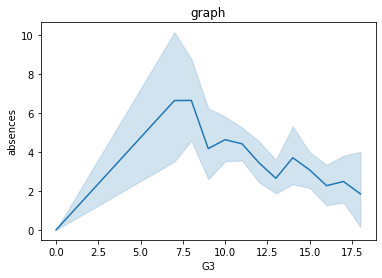

In [3]:
sns.lineplot(data=notas_df, y="absences",x="G3").set_title("graph")

In [35]:
notas_df = pd.read_csv("data/student_data.csv")
notas = notas_df.drop("G3", axis=1)

# splitting the data
x_train, x_test, y_train, y_test = train_test_split(notas, notas_df['G3'], test_size = 0.3, random_state=0)

# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [36]:
test_df = pd.read_csv("data/test_data.csv")

y_prediction = LR.predict(test_df)
y_prediction

with open(f"data/prediction_{time.time():.0f}.csv", "w+") as fp:
    fp.write(f"index,G3\n")
    for i, n in enumerate(y_prediction):
        fp.write(f"{i},{n}\n")

TODO : PARAMETER TUNING , usar stats model ou OLS regression

- [x] ler dados
- [x] regressão linear 70% dos dados `student_data.csv`
- [ ] testar com os restantes 30%
- [ ] parameter tuning !!!
- [x] prever `test_data.csv`
- [ ] alterações
- [ ] submeter 👍

helpful links:

https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/

https://datatofish.com/multiple-linear-regression-python/

https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html